In [1]:
import gym
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_config
from keras import backend as K

print(tf.__version__)
print(tf.keras.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.0.0
2.2.4-tf


Using TensorFlow backend.


In [2]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        # Specify self.layer_size which shows the number of nodes in each layer
        self.layer_sizes = np.array([self.state_dim, self.num_hidden_units, self.num_actions])
        
        # Initialize the weights of the neural network
        # self.weights is an array of dictionaries with each dictionary corresponding to 
        # the weights from one layer to the next. Each dictionary includes W and b
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))
    
    def get_action_values(self, s):
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals
    
    def get_TD_update(self, s, delta_mat):
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        # td_update has the same structure as self.weights, that is an array of dictionaries.
        # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as 
        # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
        td_update = [dict() for i in range(len(self.weights))]
         
        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
        return td_update
    
    # You may wish to read the relevant paper for more information on this weight initialization
    # (Exact solutions to the nonlinear dynamics of learning in deep linear neural networks by Saxe, A et al., 2013)
    def init_saxe(self, rows, cols):
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor
    
    # Work Required: No.
    def get_weights(self):
        return deepcopy(self.weights)
    
    # Work Required: No.
    def set_weights(self, weights):
        self.weights = deepcopy(weights)

In [3]:
class Adam():
    def __init__(self, layer_sizes, 
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            # Hint: The initialization for m and v should look very much like the initializations of the weights
            # except for the fact that initialization here is to zeroes (see description above.)
            self.m[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))
            
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        # the time step t. We can calculate these powers using an incremental product. At initialization then, 
        # beta_m_product and beta_v_product should be ...? (Note that timesteps start at 1 and if we were to 
        # start from 0, the denominator would be 0.)
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    # Work Required: Yes. Fill in the weight updates (~5-7 lines).
    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the 
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                # Hint: Follow the equations above. First, you should update m and v and then compute 
                # m_hat and v_hat. Finally, compute how much the weights should be incremented by.
                g_t = td_errors_times_gradients[i][param]
                self.m[i][param] = self.beta_m*self.m[i][param] + (1-self.beta_m)*g_t
                self.v[i][param] = self.beta_v*self.v[i][param] + (1-self.beta_v)*np.square(g_t)
                m_hat = self.m[i][param] / (1-self.beta_m_product)
                v_hat = self.v[i][param] / (1-self.beta_v_product)
                weight_update = (self.step_size / (np.sqrt(v_hat) + self.epsilon)) * m_hat
                
                weights[i][param] = weights[i][param] + weight_update
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        ### update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

In [4]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)
    
    def save_replay_buffer(self):
        self.file_count += 1
        states, actions, rewards, terminals, next_states = map(list, zip(*self.buffer))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        rewards = np.array(rewards)
        terminals = np.array(terminals)        
        np.savez("LunarLander_{}".format(self.file_count), states=states, actions=actions, rewards=rewards, next_states=next_states, terminals=terminals)

In [5]:
def softmax(action_values, tau=1.0):
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = np.divide(action_values, tau)

    # Compute the maximum preference across the actions
    max_preference = np.amax(preferences, axis=1)
    
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = np.divide(exp_preferences, reshaped_sum_of_exp_preferences)    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

In [6]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # Note that q_next_mat is a 2D array of shape (batch_size, num_actions)
    q_next_mat = current_q.get_action_values(next_states)
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # Note that probs_mat is a 2D array of shape (batch_size, num_actions)
    probs_mat = softmax(q_next_mat, tau)
    
    # Compute the estimate of the next state value, v_next_vec.
    # Hint: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # Note that v_next_vec is a 1D array of shape (batch_size,)
    v_next_vec = np.average(q_next_mat, weights=probs_mat, axis=1)
    v_next_vec = v_next_vec * (1-terminals)
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    target_vec = rewards + discount*v_next_vec
    
    # Compute action values at the current states for all actions using network
    # Note that q_mat is a 2D array of shape (batch_size, num_actions)
    q_mat = network.get_action_values(states)
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # Note that q_vec is a 1D array of shape (batch_size)
    q_vec = q_mat[batch_indices, actions]
    
    # Compute TD errors for actions taken
    # Note that delta_vec is a 1D array of shape (batch_size)
    delta_vec = target_vec - q_vec
    
    return delta_vec

In [7]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    td_update = network.get_TD_update(states, delta_mat)
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    weights = optimizer.update_weights(network.get_weights(), td_update)
    
    network.set_weights(weights)

In [8]:
class Agent:
    def __init__(self):
        self.name = "expected_sarsa_agent"
        self.total_count = 0
        
    # Work Required: No.
    def agent_init(self, agent_config):
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, state):
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_start(self, state):
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    def agent_step(self, reward, state):
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                self.total_count +=1
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network (~1 Line)
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_end(self, reward):
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):        
                self.total_count+=1
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

In [9]:
# Environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n

print(state_dim)
print(num_actions)

8
4


In [10]:
# Agent Parameters
agent_parameters = {
    'network_config': {
        'state_dim': state_dim,
        'num_hidden_units': 256,
        'num_actions': num_actions
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}

# Training Parameters
training_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    "max_steps" : 1000
}

def train_episode(env, agent, max_steps):
    done = False
    steps = 0
    episode_return = 0.0
    
    observation = env.reset()
    action = agent.agent_start(observation)

    while not done and steps<max_steps:
        steps += 1
        next_observation, reward, done, _ = env.step(action)
        episode_return += reward
        
        if (done==True):
            agent.agent_end(reward)
        else:
            action = agent.agent_step(reward, next_observation)
            observation = next_observation

    return episode_return, steps, done


def train_agent(env, agent_parameters, training_parameters):
    agent = Agent()
    agent.agent_init(agent_parameters)
    
    agent_sum_reward = np.zeros((training_parameters["num_runs"], 
                                 training_parameters["num_episodes"]))
    
    for run in range(1, training_parameters["num_runs"]+1):
        for episode in tqdm(range(1, training_parameters["num_episodes"]+1)):
            # run episode
            episode_reward, steps, done = train_episode(env, agent, training_parameters["max_steps"])
            agent_sum_reward[run - 1, episode - 1] = episode_reward

    return agent, agent_sum_reward

agent, agent_sum_reward = train_agent(env, agent_parameters, training_parameters)

100%|██████████| 300/300 [10:40<00:00,  2.14s/it]


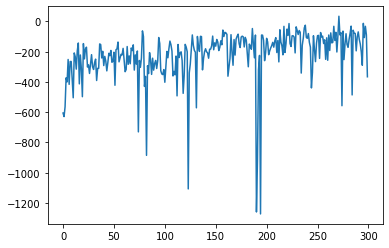

In [11]:
plt.plot(agent_sum_reward[0])

In [16]:
done = False
render = True
rewards = 0
observation = env.reset()
while not done:
    if (render is True):
        env.render()
    observation = np.expand_dims(observation, axis=0)
    action = agent.policy(observation)
    observation, reward, done, _ = env.step(action)
    rewards += reward
    
print(rewards)

-11.354411803888055


In [15]:
print(agent.total_count*20)

16774320
